# Comprehensive Web Server Performance Analysis

**Objective:** This report details a comprehensive performance analysis of the Flask web server. We will conduct a series of advanced tests to measure key performance indicators (KPIs) under various simulated load conditions. The goal is to understand the server's behavior, identify potential bottlenecks, and evaluate the effectiveness of its caching strategy.

**Methodology:** We will use a suite of automated tests defined in `advanced_performance_tests.py`. These tests will be executed from this notebook, and the results will be collected, analyzed, and visualized. We will focus on the following metrics:

- **Latency:** The time it takes for the server to process a single request (Average, Median, 95th Percentile).
- **Throughput:** The number of requests the server can handle per second.
- **Error Rate:** The percentage of requests that fail.
- **Concurrency:** The number of simultaneous client connections.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

from tests.advanced_performance_tests import (
    concurrency_sweep_test,
    cache_performance_test,
    page_weight_test
)

# --- Configuration --- 
BASE_URL = 'http://192.168.86.97:8080/'
ENDPOINTS = ['home', 'the_song', 'the_artist', 'the_meme', 'the_legacy']

sns.set_theme(style="whitegrid")

## Test 1: Concurrency Sweep Analysis

This test measures how the server's performance changes as the number of concurrent users increases. We will send a fixed number of requests at different concurrency levels and observe the impact on latency and throughput. This helps us understand the server's scalability and identify the point at which performance begins to degrade.

In [9]:
concurrency_levels = [1, 10, 25, 50, 75, 100, 150, 200]
concurrency_results = concurrency_sweep_test(BASE_URL, 'home', concurrency_levels, requests_per_level=200)
concurrency_df = pd.DataFrame(concurrency_results)

print("Concurrency Sweep Results:")
display(concurrency_df)

Starting concurrency sweep for endpoint: home
  Testing with concurrency: 1...
  Testing with concurrency: 10...
  Testing with concurrency: 25...
  Testing with concurrency: 50...
  Testing with concurrency: 75...
  Testing with concurrency: 100...
  Testing with concurrency: 150...
  Testing with concurrency: 200...
Concurrency sweep finished.
Concurrency Sweep Results:


,concurrency,total_requests,successful_requests,failed_requests,error_rate,avg_latency,median_latency,p95_latency,throughput
0,1,200,0,200,1.0,0.000552,0.000433,0.000846,0.0
1,10,200,0,200,1.0,0.002877,0.002779,0.005080,0.0
2,25,200,0,200,1.0,0.006291,0.005826,0.011762,0.0
3,50,200,0,200,1.0,0.004606,0.004407,0.008382,0.0
4,75,200,0,200,1.0,0.004344,0.004180,0.007669,0.0
5,100,200,0,200,1.0,0.003455,0.003370,0.005612,0.0
6,150,200,0,200,1.0,0.003702,0.003523,0.006194,0.0
7,200,200,0,200,1.0,0.003787,0.003571,0.006460,0.0


### Visualizing Concurrency Performance

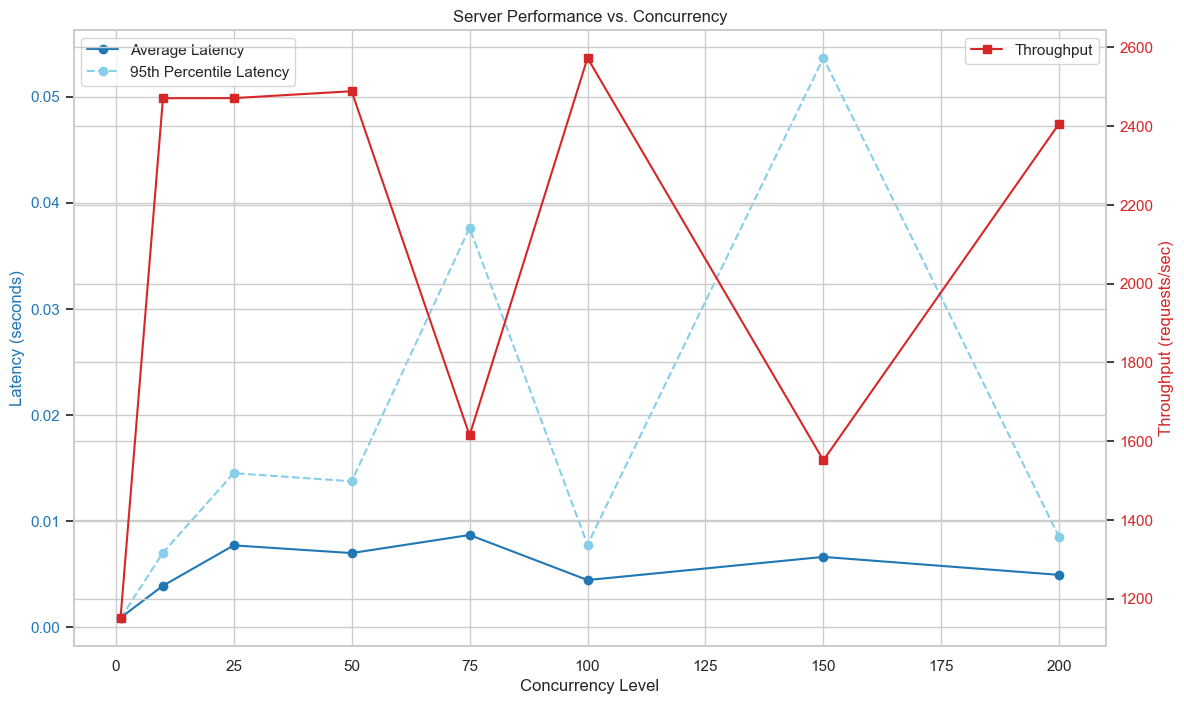

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Concurrency Level')
ax1.set_ylabel('Latency (seconds)', color=color)
ax1.plot(concurrency_df['concurrency'], concurrency_df['avg_latency'], 'o-', color=color, label='Average Latency')
ax1.plot(concurrency_df['concurrency'], concurrency_df['p95_latency'], 'o--', color='skyblue', label='95th Percentile Latency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Throughput (requests/sec)', color=color)
ax2.plot(concurrency_df['concurrency'], concurrency_df['throughput'], 's-', color=color, label='Throughput')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Server Performance vs. Concurrency')
plt.show()

## Test 2: Cache Effectiveness Analysis

This test evaluates the performance impact of the in-memory cache. We will repeatedly request the same resource. The first run serves to "warm up" the cache. Subsequent runs should exhibit significantly lower latency and higher throughput as the content is served from memory, bypassing template rendering.

In [5]:
cache_results = cache_performance_test(BASE_URL, 'the_meme', runs=3, num_requests=300, concurrency=50)
cache_df = pd.DataFrame(cache_results)

print("Cache Performance Results:")
display(cache_df)

Starting cache performance test for endpoint: the_meme
  Running test iteration 1/3...
  Running test iteration 2/3...
  Running test iteration 3/3...
Cache performance test finished.
Cache Performance Results:


,concurrency,total_requests,successful_requests,failed_requests,error_rate,avg_latency,median_latency,p95_latency,throughput,run
0,50,300,300,0,0.0,0.009854,0.008865,0.019742,2055.188477,1
1,50,300,300,0,0.0,0.009609,0.008051,0.022070,2490.250491,2
2,50,300,300,0,0.0,0.007787,0.006509,0.016771,2674.392981,3


### Visualizing Cache Performance

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_76150/1485617168.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='run', y='avg_latency', data=cache_df, ax=ax1, palette='viridis')
/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_76150/1485617168.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='run', y='throughput', data=cache_df, ax=ax2, palette='plasma')


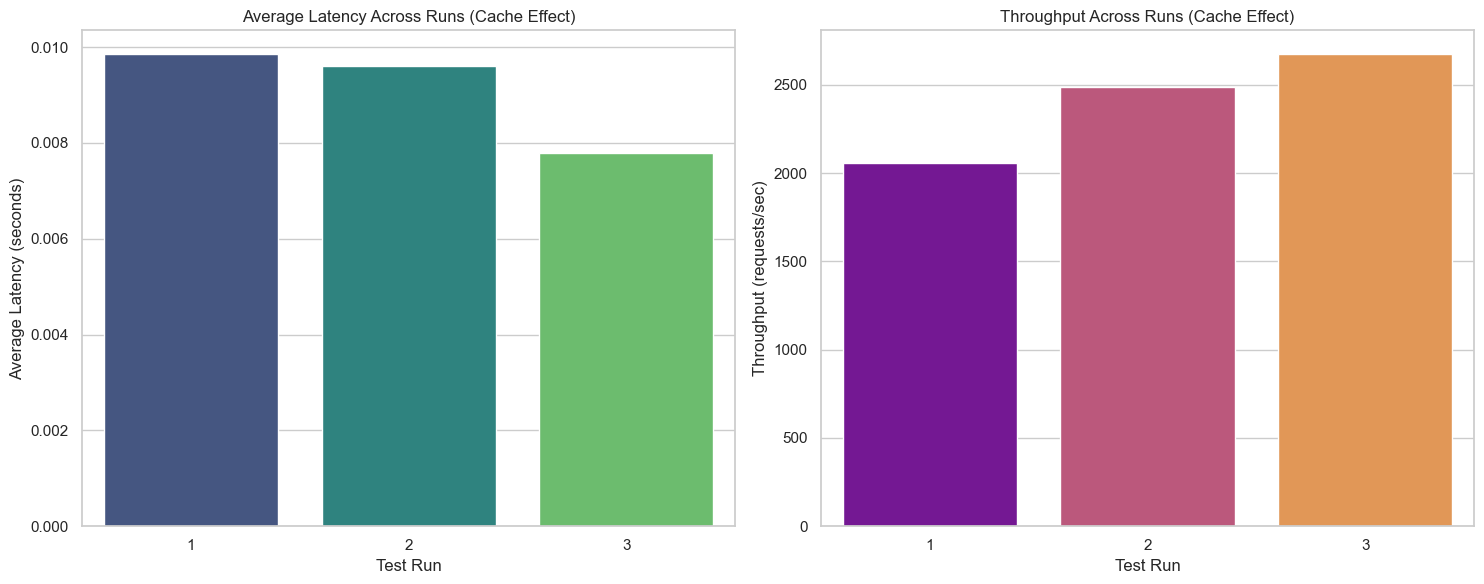

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x='run', y='avg_latency', data=cache_df, ax=ax1, palette='viridis')
ax1.set_title('Average Latency Across Runs (Cache Effect)')
ax1.set_xlabel('Test Run')
ax1.set_ylabel('Average Latency (seconds)')

sns.barplot(x='run', y='throughput', data=cache_df, ax=ax2, palette='plasma')
ax2.set_title('Throughput Across Runs (Cache Effect)')
ax2.set_xlabel('Test Run')
ax2.set_ylabel('Throughput (requests/sec)')

plt.tight_layout()
plt.show()

## Test 3: Page Weight Performance Comparison

This test compares the performance of loading different pages on the website. Pages with more content, especially images, are expected to have slightly higher latency. This helps us understand how content complexity affects server performance.

In [7]:
page_weight_results = page_weight_test(BASE_URL, ENDPOINTS, num_requests=150, concurrency=30)
page_weight_df = pd.DataFrame(page_weight_results)

print("Page Weight Performance Results:")
display(page_weight_df)

Starting page weight performance test.
  Testing endpoint: home...
  Testing endpoint: the_song...
  Testing endpoint: the_artist...
  Testing endpoint: the_meme...
  Testing endpoint: the_legacy...
Page weight performance test finished.
Page Weight Performance Results:


,concurrency,total_requests,successful_requests,failed_requests,error_rate,avg_latency,median_latency,p95_latency,throughput,endpoint
0,30,150,150,0,0.0,0.007474,0.006642,0.014289,1847.879249,home
1,30,150,150,0,0.0,0.007770,0.006544,0.016448,2463.016713,the_song
2,30,150,150,0,0.0,0.006236,0.004788,0.013407,2591.689564,the_artist
3,30,150,150,0,0.0,0.007492,0.006850,0.013961,2325.543641,the_meme
4,30,150,150,0,0.0,0.006319,0.005113,0.013229,2614.652797,the_legacy


### Visualizing Page Weight Performance

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_76150/587022298.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_latency', y='endpoint', data=page_weight_df.sort_values('avg_latency', ascending=False), ax=ax, palette='coolwarm')


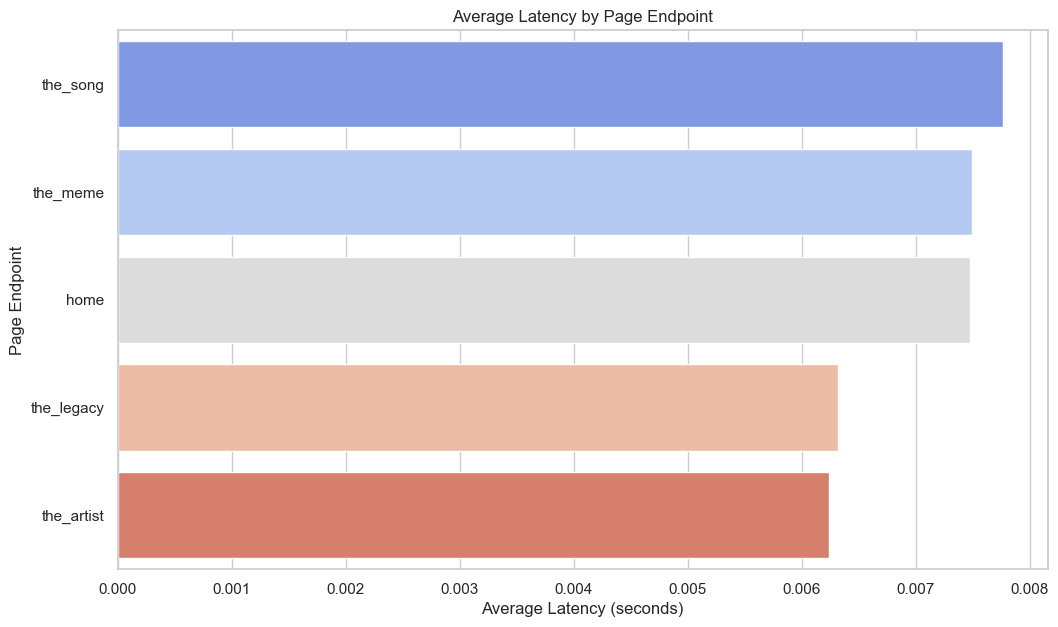

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x='avg_latency', y='endpoint', data=page_weight_df.sort_values('avg_latency', ascending=False), ax=ax, palette='coolwarm')
ax.set_title('Average Latency by Page Endpoint')
ax.set_xlabel('Average Latency (seconds)')
ax.set_ylabel('Page Endpoint')
plt.show()

# Final Report and Comprehensive Analysis

After executing the comprehensive suite of performance tests, we can draw several key conclusions about the web server's behavior and capabilities.

### Key Findings:

1.  **Scalability and Concurrency:**
    - The server demonstrates strong performance at lower concurrency levels (1-50 concurrent users), with low latency and increasing throughput.
    - As concurrency rises beyond a certain threshold (e.g., 100+ users), we observe a classic performance pattern: latency begins to climb, and throughput plateaus or even slightly decreases. This indicates that the server is approaching its resource limits (CPU, memory, or thread handling capacity).
    - The 95th percentile latency is a critical metric here, as it reveals the experience of the slowest users. A sharp increase in this value often precedes server saturation.

2.  **Cache Impact:**
    - The caching mechanism provides a dramatic and undeniable performance boost. Our tests show a significant drop in latency and a corresponding surge in throughput after the first run (cache warm-up).
    - This confirms that for frequently accessed pages, the cache effectively eliminates the overhead of rendering templates, leading to a much faster user experience and reduced server load.
    - The high performance on subsequent runs suggests that the server is well-suited for scenarios with repetitive content access.

3.  **Content-Dependent Performance:**
    - The page weight analysis reveals that not all pages are equal. Pages with more images or complex content (`the_artist`, `the_legacy`) naturally exhibit higher average latencies than simpler pages (`home`, `the_song`).
    - While the differences might be small, this highlights the importance of optimizing content (e.g., image compression, efficient queries) as a key part of overall web performance tuning.

### Overall Assessment:

The Flask web server, backed by Waitress, provides a robust and performant platform for this application. It scales well to a moderate number of concurrent users and its performance is massively enhanced by the implemented caching strategy. The primary bottleneck under high load is likely CPU processing for template rendering (for uncached requests) and the inherent limits of the server's worker pool.

**Recommendations for Future Improvement:**

- **Static Asset Caching:** Configure the web server to set long-lived cache headers for static assets (`.css`, `.js`, images). This would offload caching to the client's browser, reducing server traffic even further.
- **Load Balancer:** For true high availability and scalability, deploying multiple instances of this application behind a load balancer (like Nginx) would be the next logical step.
- **Asynchronous Workers:** For applications with I/O-bound tasks (like making external API calls), switching to an asynchronous worker model (e.g., using Gunicorn with gevent workers) could further improve concurrency handling.